In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import sys
sys.path.append("../")

In [3]:
import logging
import json
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
import torch
from source.evaluate_models import evaluate_model
from source.losses import preference_loss_function
from source.mlp import MLP
from source.training import train_reward_model, get_norm_dict
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

d:\work\eleutherai\rlhf_fairness\rlhf-fairness\env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# state_action_features = ['default_rate-group_1', 'default_rate-group_2', 
#                          'acceptance_rate-group_1', 'acceptance_rate-group_2', 
#                          'average_credit_score-group_2', 'average_credit_score-group_1',
#                          'applicant_credit_group', 'applicant_group_membership', 'agent_action']

reward_model_features = ['default_rate-group_1', 'default_rate-group_2', 
                         'acceptance_rate-group_1', 'acceptance_rate-group_2', 
                         'average_credit_score-group_2', 'average_credit_score-group_1',
                         'applicant_credit_group', 'applicant_group_membership', 'agent_action'
                        ]
# reward_model_features = ['applicant_credit_group', 'agent_action']

In [4]:
def n_sample_trajectory_df(input_df, n_sample_points = 20):
    trajectory_df = input_df.copy()
    if len(trajectory_df)//2 > n_sample_points:
        sample_step_size = len(trajectory_df) // n_sample_points
        trajectory_df = trajectory_df.reset_index(drop=True)
        sample_index = [i for i in range(len(trajectory_df)) if i%sample_step_size == 0]
        trajectory_df_sampled = trajectory_df[trajectory_df.index.isin(sample_index)]
        return trajectory_df_sampled
    else:
        return trajectory_df
    
def sample_trajectory_features(input_df, base_features, n_sample_points = 20):
    window_size = len(input_df)//n_sample_points
    features = {"min": input_df[base_features].min().to_dict(),
                "max": input_df[base_features].max().to_dict(),
                "mean": input_df[base_features].mean().to_dict(),
                "std": input_df[base_features].std().to_dict()
               }
    tmp_features_ma = input_df[base_features].rolling(window=window_size//2).mean().dropna(subset=base_features)
    tmp_features_ma_sampled = sample_trajectory_uniform(tmp_features_ma, n_sample_points=n_sample_points)
    
    features_df_ma_vals = []
    features_df_ma_names = []
    tmp_input_df = tmp_features_ma_sampled.reset_index(drop=True)
    original_cols = tmp_input_df.columns
    for idx, row in tmp_input_df.iterrows():
        features_df_ma_vals += list(row.values)
        features_df_ma_names += [f"{i}_{idx}" for i in original_cols]

    features_df_ma = pd.DataFrame(features_df_ma_vals, index=features_df_ma_names).T
    
    feature_df = []
    for k, v in features.items():
        tmp_df = pd.DataFrame.from_dict(v, orient="index").T
        tmp_df.columns = [f"{i}_{k}" for i in tmp_df.columns]
        feature_df.append(tmp_df)

    feature_df = pd.concat(feature_df + [features_df_ma], axis=1)
    return feature_df

def get_accuracy_result(metrics_report_history):
    acc_list = []
    for k, v in metrics_report_history.items():
        acc_list.append(v['accuracy'])
    
    print("Accuracy history: ", acc_list)
    print("Mean (5-fold): ", np.array(acc_list).mean())
    print("Std (5-fold): ", np.array(acc_list).std())
    return acc_list

def convert_filenames_to_trajectories(df,
                                      state_action_features,
                                      target,
                                      trajecotry_folder="../data/trajectories", 
                                      n_sample_points=20,
                                      n_sample=-1
                                     ):
    res_df = pd.DataFrame()
    modelling_df = df.copy().head(n_sample)
    for idx, row in modelling_df.iterrows():
        option_a_file = row['Trajectory_A']
        option_b_file = row['Trajectory_B']
        tmp_df_a = pd.read_csv(f"{trajecotry_folder}/{option_a_file}", index_col=[0])
        tmp_df_b = pd.read_csv(f"{trajecotry_folder}/{option_b_file}", index_col=[0])

#         tmp_df_a_sampled = n_sample_trajectory_df(tmp_df_a, n_sample_points=n_sample_points)
#         tmp_df_b_sampled = n_sample_trajectory_df(tmp_df_b, n_sample_points=n_sample_points)  
        tmp_df_a_sampled = sample_trajectory_features(tmp_df_a, state_action_features, n_sample_points=n_sample_points)
        tmp_df_b_sampled = sample_trajectory_features(tmp_df_b, state_action_features, n_sample_points=n_sample_points)  
        
        tmp_df_a_sampled = tmp_df_a_sampled[state_action_features]
        tmp_df_b_sampled = tmp_df_b_sampled[state_action_features]

        tmp_df_a_sampled.columns = [f"{i}_a" for i in tmp_df_a_sampled.columns]
        tmp_df_b_sampled.columns = [f"{i}_b" for i in tmp_df_b_sampled.columns]
        tmp_df = pd.concat([tmp_df_a_sampled, tmp_df_b_sampled], axis=1)
        tmp_df[target] = 0 if row[target] == 'a' else 1        
        res_df = res_df.append(tmp_df)
    res_df = res_df.reset_index(drop=True)
    return res_df

In [5]:
target = "target"
decision_col = 'Decision_fair'

save_dir = "./"
reward_model_name = "fair_gpt_reward_model"
synthetic_preferences_path = "D:\\Work\\EleutherAI\\fairness_gym\\ml-fairness-gym\\fixed_gpt_preferences_formatted_all.csv"


In [6]:
preferences_df = pd.read_csv(synthetic_preferences_path)

preferences_df_filtered = preferences_df[['Trajectory_A', 'Trajectory_B', decision_col]]
preferences_df_filtered = preferences_df_filtered.dropna(subset=[decision_col])
preferences_df_filtered = preferences_df_filtered[preferences_df_filtered[decision_col].isin(['a', 'b'])]
print(preferences_df_filtered[decision_col].value_counts())

b    3216
a    1588
Name: Decision_fair, dtype: int64


In [7]:
# Separate rows for values 'a' and 'b'
df_a = preferences_df_filtered[preferences_df_filtered[decision_col] == 'a']
df_b = preferences_df_filtered[preferences_df_filtered[decision_col] == 'b']

# Determine the minimum count of rows
min_count = min(len(df_a), len(df_b))

# Sample equal number of rows for 'a' and 'b'
df_a = df_a.sample(n=min_count, random_state=42)
df_b = df_b.sample(n=min_count, random_state=42)

# Concatenate the sampled DataFrames
filtered_df = pd.concat([df_a, df_b])

# Reset the index of the filtered DataFrame
filtered_df.reset_index(drop=True, inplace=True)

In [8]:
torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device(type='cuda')

In [9]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
torch.manual_seed(99)

class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.X = torch.tensor(dataframe[features].values).float()
        self.y = torch.tensor(dataframe[target].values).float()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i): 
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)
        
        x = x.to(self.device)
        y = self.y[i].to(self.device)
        return x, y

In [10]:

#######################################
### The model and learning algorithm ##
#######################################

class ShallowRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units, num_layers=1, out_features=1, name="reward_model"):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = num_layers
        self.name = name

        self.lstm = nn.LSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )
        self.linear = nn.Linear(in_features=self.hidden_units, out_features=out_features)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0]).flatten()  # First dim of Hn is num_layers, which is set to 1 above.
        return torch.sigmoid(out)
    
def train_model(data_loader, model, loss_function, optimizer, return_loss=False, verbose=False):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()
    
    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / (num_batches+1*10**-9)
    
    if verbose:
        print(f"Train loss: {avg_loss}")
    
    if return_loss:
        return avg_loss

def test_model(data_loader, model, loss_function, return_loss=False, verbose=False):
    
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / (num_batches + 1*10**-9)
    
    if verbose:
        print(f"Test loss: {avg_loss}")
    
    if return_loss:
        return avg_loss
    
def predict(data_loader, model):

    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)
    
    return output

def get_trajectories_comparison_df(df,
                                  state_action_features,
                                  target,
                                  trajecotry_folder="../data/trajectories", 
                                  n_sample_points=20
                                 ):
    res_df = pd.DataFrame()
    modelling_df = df.copy()
    for idx, row in modelling_df.iterrows():
        option_a_file = row['Trajectory_A']
        option_b_file = row['Trajectory_B']
        tmp_df_a = pd.read_csv(f"{trajecotry_folder}/{option_a_file}", index_col=[0])
        tmp_df_b = pd.read_csv(f"{trajecotry_folder}/{option_b_file}", index_col=[0])

        tmp_df_a_sampled = n_sample_trajectory_df(tmp_df_a, n_sample_points=n_sample_points)
        tmp_df_b_sampled = n_sample_trajectory_df(tmp_df_b, n_sample_points=n_sample_points)    
        tmp_df_a_sampled = tmp_df_a_sampled[state_action_features]
        tmp_df_b_sampled = tmp_df_b_sampled[state_action_features]

        tmp_df_a_sampled.columns = [f"{i}_a" for i in tmp_df_a_sampled.columns]
        tmp_df_b_sampled.columns = [f"{i}_b" for i in tmp_df_b_sampled.columns]
        tmp_df = pd.concat([tmp_df_a_sampled, tmp_df_b_sampled], axis=1)

        tmp_df[target] = 0 if row[target] == 'a' else 1  
        res_df = res_df.append(tmp_df)
    res_df = res_df.reset_index(drop=True)
    return res_df
    
def get_dataloader(df_train, df_test, features, target, sequence_length, batch_size, torch_seed=101):
    # Create dataloader objects
    torch.manual_seed(torch_seed)
#     tmp_df_train, tmp_df_test = normalize_train_test(df_train, df_test)
    train_dataset = SequenceDataset(df_train, target=target, features=features, sequence_length=sequence_length)
    test_dataset = SequenceDataset(df_test, target=target, features=features, sequence_length=sequence_length)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader
    

In [11]:
from source.mlp import MLP

In [12]:
n_sample_points = 20
X = filtered_df.drop([decision_col], axis=1)
y = filtered_df[decision_col]

report_history = {}
cm_history = {}
# Training the model and evaluate with k-fold
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=1)
train_df = pd.concat([X_tr, y_tr], axis=1)
test_df = pd.concat([X_te, y_te], axis=1)
# Attach the trajectories to the file names
train_trajectories = get_trajectories_comparison_df(train_df,
                              reward_model_features,
                              target=decision_col,
                              trajecotry_folder="../data/trajectories", 
                              n_sample_points=n_sample_points
                             )
test_trajectories = get_trajectories_comparison_df(test_df,
                              reward_model_features,
                              target=decision_col,
                              trajecotry_folder="../data/trajectories", 
                              n_sample_points=n_sample_points
                             )
# for i in range(1):
    # Split the file names into training and testing sets
    
print("Trajectories generated: ")

Trajectories generated: 


In [13]:
def preference_loss_function_3(sum_a, sum_b, decisions):
    '''
    sum_a -> batch_size, 1
    sum_b -> batch_size, 1
    '''
    sum_a = sum_a.unsqueeze(1)
    sum_b = sum_b.unsqueeze(1)
    stacked_tensor = torch.cat([sum_a, sum_b], dim=1)
    stacked_tensor = stacked_tensor.to(torch.float32)
    decisions = decisions.to(torch.float32)
    loss = F.cross_entropy(stacked_tensor, decisions)
    return loss

In [14]:
sum_a = torch.rand(20).to(torch.device('cuda'))
sum_b = torch.rand(20).to(torch.device('cuda'))
decisions = torch.rand(20,2).to(torch.device('cuda'))
l = preference_loss_function_3(sum_a, sum_b, decisions)
print(l)

tensor(0.7755, device='cuda:0')


In [15]:
import logging
import os
import numpy as np
import torch
import torch.nn.functional as F
from tqdm.notebook import tqdm
from source.datasets import TabularDataset
def train_reward_model(model,
                       input_dim,
                       train_loader,
                       loss_function,
                       learning_rate,
                       num_epochs,
                       batch_size,
                       save_dir,
                       ):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    logging.info("Training with: {}".format(device))
    model.train()
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses = [-np.inf]
    for epoch in range(num_epochs):
        tmp_losses = []
        reward_A_list = []
        reward_B_list = []
        accuracy_list = []
        # with train_loader as batches:
        # batches.set_description(f"Training - Epoch {epoch + 1} - Loss {round(losses[-1], 4)}")
        for features, decisions in train_loader:
            optimizer.zero_grad()
            features = features.to(device)
            feature_last_dim = features.size(2)
            curr_batch_size = features.size(0)
            features_a = features[:, :input_dim, :]
            features_a = features_a.transpose(1, 2)
            features_a = features_a.contiguous().view(-1, input_dim).to(device)
            
            features_b = features[:, input_dim:, :]
            features_b = features_b.transpose(1, 2)
            features_b = features_b.contiguous().view(-1, input_dim).to(device)
            
            reward_A = model(features_a)
            reward_B = model(features_b)
            
            reward_A = torch.sum(reward_A.view(curr_batch_size, -1), 1)
            reward_B = torch.sum(reward_B.view(curr_batch_size, -1), 1)
            decisions = F.one_hot(decisions.to(torch.int64), num_classes=2)
            loss = loss_function(reward_A, reward_B, decisions)
            
            reward_A = reward_A.unsqueeze(1)
            reward_B = reward_B.unsqueeze(1)
            stacked_tensor = torch.cat([reward_A, reward_B], dim=1)
            stacked_tensor = stacked_tensor.to(torch.float32)
            curr_accuracy = get_accuracy(stacked_tensor, decisions)
            accuracy_list.append(curr_accuracy.item())
            
            loss.backward()
            optimizer.step()
            tmp_losses.append(loss.item())
        
        acc = sum(accuracy_list) / len(accuracy_list)
        print("ON EPOCH {} Training Accuracy: {}: ".format(epoch, acc))    
        losses.append(np.mean(tmp_losses))
            # batches.set_postfix({"loss": np.mean(losses)})

    torch.save(model, os.path.join(save_dir, model.name + ".pt"))
    return losses, model

def get_norm_dict(df_train, target):
    mean_dict = {}
    stdev_dict = {}
    for c in df_train.columns:
        if c != target:
            mean_dict[c] = df_train[c].mean()
            stdev_dict[c] = df_train[c].std()
    return mean_dict, stdev_dict


def normalize_df(df, decision_col, mean_dict, stdev_dict):
    for c in df.columns:
        if c != decision_col:
            if c in stdev_dict and stdev_dict[c] != 0:
                df[c] = (df[c] - mean_dict[c]) / stdev_dict[c]
            else:
                df[c] = 0
    return df

In [16]:
reward_model_features_extended = [f"{i}_a" for i in reward_model_features] + [f"{i}_b" for i in reward_model_features]
reward_model_features_extended

['default_rate-group_1_a',
 'default_rate-group_2_a',
 'acceptance_rate-group_1_a',
 'acceptance_rate-group_2_a',
 'average_credit_score-group_2_a',
 'average_credit_score-group_1_a',
 'applicant_credit_group_a',
 'applicant_group_membership_a',
 'agent_action_a',
 'default_rate-group_1_b',
 'default_rate-group_2_b',
 'acceptance_rate-group_1_b',
 'acceptance_rate-group_2_b',
 'average_credit_score-group_2_b',
 'average_credit_score-group_1_b',
 'applicant_credit_group_b',
 'applicant_group_membership_b',
 'agent_action_b']

In [17]:
class MLP(torch.nn.Module):
    def __init__(self, name, layer_dims, out_act=None):
        super().__init__()
        self.name = name
        self.layers = torch.nn.ModuleList()
        for i in range(len(layer_dims) - 1):
            self.layers.append(torch.nn.Linear(layer_dims[i], layer_dims[i + 1]))
            if i < len(layer_dims) - 2:
                torch.nn.init.kaiming_uniform_(
                    self.layers[2 * i].weight, nonlinearity="relu"
                )
                self.layers.append(torch.nn.ReLU())
            else:
                torch.nn.init.xavier_uniform_(self.layers[2 * i].weight)
        if out_act == "sigmoid":
            self.layers.append(torch.nn.Sigmoid())
#         print(self.layers)

    def forward(self, X):
        for layer in self.layers:
            X = layer(X)
        return X

In [18]:
from sklearn import metrics
import pandas as pd
import numpy as np


def get_accuracy(stacked_tensor, preferences):
    softmax_stacked_tensor = F.softmax(stacked_tensor, dim=1)
    preds_correct = torch.argmax(preferences, dim=1) == torch.argmax(softmax_stacked_tensor, dim=1)
    accuracy = torch.mean(preds_correct.float())
    return accuracy

def evaluate_model_new(model, test_loader, input_dim):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
#     y_pred = []
#     y_true = []
    accuracy_list = []
#     with torch.no_grad():
    with torch.inference_mode():
        for features, y in test_loader:
            features = features.to(device)
            feature_last_dim = features.size(2)
            curr_batch_size = features.size(0)
            features_a = features[:, :input_dim, :]  
            features_a = features_a.transpose(1, 2)
            features_a = features_a.contiguous().view(-1, input_dim).to(device)
            
            features_b = features[:, input_dim:, :]
            features_b = features_b.transpose(1, 2)
            features_b = features_b.contiguous().view(-1, input_dim).to(device)
            reward_A = model(features_a)
            reward_B = model(features_b)
            
            sum_a = torch.sum(reward_A.view(curr_batch_size, -1), 1)
            sum_b = torch.sum(reward_B.view(curr_batch_size, -1), 1)
            y = F.one_hot(y.to(torch.int64), num_classes=2)
            
            sum_a = sum_a.unsqueeze(1)
            sum_b = sum_b.unsqueeze(1)
            stacked_tensor = torch.cat([sum_a, sum_b], dim=1)
            stacked_tensor = stacked_tensor.to(torch.float32)
            curr_accuracy = get_accuracy(stacked_tensor, y)
            accuracy_list.append(curr_accuracy.item())
#             tmp_y_pred = list(map(float, torch.gt(reward_B.detach().cpu().float(), reward_A.detach().cpu().float()).tolist()))
#             y_pred += tmp_y_pred
#             y_true += y.tolist()
            
    
#     clf_rep = metrics.precision_recall_fscore_support(y_true, y_pred)
#     cm_df = pd.DataFrame(metrics.confusion_matrix(y_true, y_pred))
#     out_dict = {
#                  "precision" :clf_rep[0].round(2),
#                  "recall" : clf_rep[1].round(2),
#                  "f1-score" : clf_rep[2].round(2),
#                  "support" : clf_rep[3],
#                  "accuracy": class_acc.round(2)
#                 }
    
#     out_df = pd.DataFrame(out_dict)
#     avg_tot = (out_df.apply(lambda x: round(x.mean(), 2) if x.name!="support" else  round(x.sum(), 2)).to_frame().T)
#     avg_tot.index = ["avg/total"]
#     out_df = out_df.append(avg_tot)
#     return out_df, cm_df
    test_set_accuracy = sum(accuracy_list) / len(accuracy_list)
    return test_set_accuracy 

In [19]:
num_epochs = 50
n_sample_points = 20

# num_hidden_units = 100
batch_size = 256
learning_rate = 1E-5

# reward_model_features_extended = [f"{i}_a" for i in reward_model_features] + [f"{i}_b" for i in reward_model_features]
# Normalization
train_mean_dict, train_stdev_dict = get_norm_dict(train_trajectories, decision_col)
df_train_norm = normalize_df(train_trajectories, decision_col, train_mean_dict, train_stdev_dict)

df_test_norm = normalize_df(test_trajectories, decision_col, train_mean_dict, train_stdev_dict)
# test_loader = get_dataloader(df_test_norm, 
#                        reward_model_features_extended, 
#                        decision_col, 
#                        n_sample_points, 
#                        batch_size, 
#                        torch_seed=101, 
#                        )
# Get dataloader
train_loader, test_loader = get_dataloader(df_train_norm,
                               df_test_norm,
                               reward_model_features_extended, 
                               decision_col, 
                               n_sample_points, 
                               batch_size, 
                               torch_seed=101, 
                           )
# Create model object
model_input_dim = len(reward_model_features_extended)//2
#     reward_model = ShallowRegressionLSTM(name = "fair_lstm_reward_model",
#                                   num_sensors=model_input_dim, 
#                                   num_layers=1, 
#                                   hidden_units=num_hidden_units)

model_hidden_config = [256, 256, 128, 128, 64, 64]
reward_model = MLP(
    name='mlp_with_paper_loss',
    layer_dims=[model_input_dim] + model_hidden_config + [1],
    out_act=None
)
# print([[model_input_dim] + model_hidden_config + [1]])
# Training
losses, reward_model = train_reward_model(
        reward_model,
        model_input_dim,
        train_loader,
        preference_loss_function_3,
        learning_rate,
        num_epochs,
        batch_size,
        save_dir
    )
# Normalize test set

# # K-Fold testing
# report_df, cm_df = evaluate_model_new(reward_model, test_loader, model_input_dim)
# report_history[i] = report_df
# cm_history[i] = cm_df
accuracy = evaluate_model_new(reward_model, test_loader, model_input_dim)
print(accuracy)

ON EPOCH 0 Training Accuracy: 0.5017077575376885: 
ON EPOCH 1 Training Accuracy: 0.5021592336683417: 
ON EPOCH 2 Training Accuracy: 0.5012843234455167: 
ON EPOCH 3 Training Accuracy: 0.5025854721740263: 
ON EPOCH 4 Training Accuracy: 0.5058607773565168: 
ON EPOCH 5 Training Accuracy: 0.5054121053398554: 
ON EPOCH 6 Training Accuracy: 0.5038389494670695: 
ON EPOCH 7 Training Accuracy: 0.5087631236967729: 
ON EPOCH 8 Training Accuracy: 0.5058832108674935: 
ON EPOCH 9 Training Accuracy: 0.5072544645424464: 


KeyboardInterrupt: 

In [64]:
def test_one_sample(model, test_loader, input_dim):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
    features, y = next(iter(test_loader))
    features = features.to(device)
    feature_last_dim = features.size(2)
    curr_batch_size = features.size(0)
    features_a = features[:, :input_dim, :]
    features_a = features_a.transpose(1, 2)
    features_a = features_a.contiguous().view(-1, input_dim).to(device)

    features_b = features[:, input_dim:, :]
    features_b = features_b.transpose(1, 2)
    features_b = features_b.contiguous().view(-1, input_dim).to(device)
    
    reward_A = model(features_a)
    reward_B = model(features_b)

    sum_a = torch.sum(reward_A.view(curr_batch_size, -1), 1)
    sum_b = torch.sum(reward_B.view(curr_batch_size, -1), 1)
    y = F.one_hot(y.to(torch.int64), num_classes=2)

    sum_a = sum_a.unsqueeze(1)
    sum_b = sum_b.unsqueeze(1)
    stacked_tensor = torch.cat([sum_a, sum_b], dim=1)
    stacked_tensor = stacked_tensor.to(torch.float32)
    softmax_stacked_tensor = F.softmax(stacked_tensor, dim=1)
    
    for i in range(256):
        print(softmax_stacked_tensor[i,:], y[i])

test_one_sample(reward_model, test_loader, model_input_dim)

tensor([0.4644, 0.5356], device='cuda:0', grad_fn=<SliceBackward0>) tensor([0, 1], device='cuda:0')
tensor([0.4662, 0.5338], device='cuda:0', grad_fn=<SliceBackward0>) tensor([0, 1], device='cuda:0')
tensor([0.4390, 0.5610], device='cuda:0', grad_fn=<SliceBackward0>) tensor([0, 1], device='cuda:0')
tensor([0.4713, 0.5287], device='cuda:0', grad_fn=<SliceBackward0>) tensor([0, 1], device='cuda:0')
tensor([0.4284, 0.5716], device='cuda:0', grad_fn=<SliceBackward0>) tensor([0, 1], device='cuda:0')
tensor([0.4656, 0.5344], device='cuda:0', grad_fn=<SliceBackward0>) tensor([0, 1], device='cuda:0')
tensor([0.4228, 0.5772], device='cuda:0', grad_fn=<SliceBackward0>) tensor([0, 1], device='cuda:0')
tensor([0.4599, 0.5401], device='cuda:0', grad_fn=<SliceBackward0>) tensor([0, 1], device='cuda:0')
tensor([0.4172, 0.5828], device='cuda:0', grad_fn=<SliceBackward0>) tensor([0, 1], device='cuda:0')
tensor([0.4547, 0.5453], device='cuda:0', grad_fn=<SliceBackward0>) tensor([0, 1], device='cuda:0')


tensor([0.4102, 0.5898], device='cuda:0', grad_fn=<SliceBackward0>) tensor([1, 0], device='cuda:0')
tensor([0.4441, 0.5559], device='cuda:0', grad_fn=<SliceBackward0>) tensor([1, 0], device='cuda:0')
tensor([0.4102, 0.5898], device='cuda:0', grad_fn=<SliceBackward0>) tensor([1, 0], device='cuda:0')
tensor([0.4431, 0.5569], device='cuda:0', grad_fn=<SliceBackward0>) tensor([1, 0], device='cuda:0')
tensor([0.3992, 0.6008], device='cuda:0', grad_fn=<SliceBackward0>) tensor([1, 0], device='cuda:0')
tensor([0.4292, 0.5708], device='cuda:0', grad_fn=<SliceBackward0>) tensor([1, 0], device='cuda:0')
tensor([0.4160, 0.5840], device='cuda:0', grad_fn=<SliceBackward0>) tensor([1, 0], device='cuda:0')
tensor([0.4291, 0.5709], device='cuda:0', grad_fn=<SliceBackward0>) tensor([1, 0], device='cuda:0')
tensor([0.4369, 0.5631], device='cuda:0', grad_fn=<SliceBackward0>) tensor([1, 0], device='cuda:0')
tensor([0.4450, 0.5550], device='cuda:0', grad_fn=<SliceBackward0>) tensor([1, 0], device='cuda:0')


In [73]:
reward_model

MLP(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)

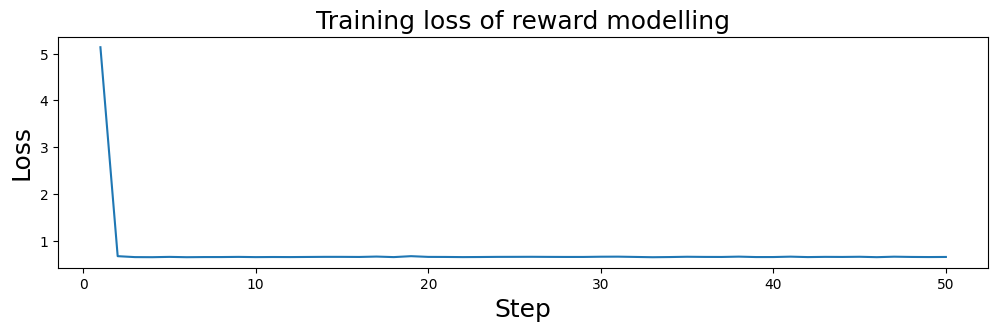

In [105]:
plt.figure(figsize=(12, 3))
plt.plot(losses)
plt.title("Training loss of reward modelling", size=18)
plt.xlabel("Step", size=18)
plt.ylabel("Loss", size=18)
plt.show()


In [273]:
for k, v in report_history.items():
    print(k)
    display(v)
    

0


,precision,recall,f1-score,support,accuracy
0,0.32,0.46,0.38,1060.0,0.45
1,0.77,0.65,0.70,2920.0,0.58
avg/total,0.55,0.56,0.54,3980.0,0.52


In [274]:
for k, v in cm_history.items():
    print(k)
    display(v)
    

0


,0,1
0,483,577
1,1020,1900


In [17]:
train_df = preferences_df_filtered[preferences_df_filtered.index.isin(train_index)]
test_df = preferences_df_filtered[preferences_df_filtered.index.isin(test_index)]
# Training
features, decisions = train_df[state_action_features].to_numpy(), train_df[target].to_numpy()
reward_model = MLP(name=reward_model_name, layer_dims=[features.shape[1]+1] + model_hidden_config + [1], out_act=None)
losses = train_reward_model(
    reward_model,
    features,
    decisions,
    loss_function=preference_loss_function,
    learning_rate=0.0001,
    num_epochs=num_epochs,
    batch_size=256,
    save_dir=save_dir)

# K-Fold testing
test_features, test_decisions = test_df[state_action_features].to_numpy(), test_df[target].to_numpy()
predictions, metrics_report = evaluate_model(reward_model, test_features, test_decisions)
metrics_report_history[i] = metrics_report



NameError: name 'train_index' is not defined

***
### End of Notebook